# LSTM

In [1]:
!pip install googletrans

In [2]:
!pip install wordcloud

In [38]:
# utility
import numpy as np 
import pandas as pd 
import string
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# model 
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
import keras
from keras.utils.np_utils import to_categorical

#nltk and sklearn
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# File path
import os
import os.path
from os import path

# Translator
import googletrans
from googletrans import Translator

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

### Data

In [39]:
# original english file
filename  = 'Eng-Hin-data/hindi-anot-shuffled'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.columns = ['Text', 'Label']

In [40]:
orig_df["Text"] = orig_df["Text"].astype(str)
orig_df["Label"] = orig_df["Label"].astype(str)

In [41]:
# Displaying eg tweet
orig_df.Text[6]

"'आज के दिन ही मेरा क्रिकेट प्रेम भी समाप्त हो गया"

In [42]:
sentiment =  orig_df['Label'].values

In [43]:
orig_df.groupby('Label').describe()

Text                                                               
      count unique                                                top freq
Label                                                                     
0      3244   3243  #AllahDoesNotNeedQurbani कबीर परमात्मा ने कहा ...    2
1      2174   2174                          '@munir801141 माशा अल्लाह    1
2      3375   3373                                                  0    3

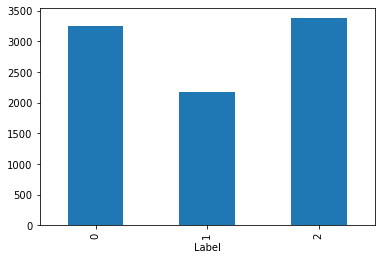

In [44]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
orig_df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [45]:
# For entire dataset sentences for each labels 
orig_df.Label.value_counts()

2    3375
0    3244
1    2174
Name: Label, dtype: int64

In [46]:
data=data.sample(frac=1).reset_index(drop=True)
data

,Text,Label
0,'@azizkavish माशाअल्लाह.💐,1
1,"'@PNRai1 मुसलमान भारत में ""Islamic study"" करके...",2
2,"""लो हम भी आ गए इसकी ज़द में कोरोना किसी के बाप...",2
3,'जब भी कभी दिल को प्यास की शिद्दत हो दिल बेचैन...,1
4,'तमाम आशिकें रसूलों के लिए आमीन 💞🤲💞,1
...,...,...
10118,'@Siddhant01 इंशाअल्लाह जल्द सही ठीक हो जायेगी...,1
10119,'@SanjayAzadSln अबे जेहादी अपना नाम भी बदल ले ...,2
10120,'दलित का घर जला जिहादी ने जलाया इसलिए कांग्रेस...,2
10121,'@rpgsenagopal राहुल प्रियंका गांधी सेना जिंदाबाद,0


### Data Preprocessing

In [47]:
def clean_text(text):
    text = text.lower()
    
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    text = text.lower()
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [48]:
stopword=open("Devanagari/stopwords.txt","r")
stop_words=[]
# pre-process stopword
for i in stopword:
    i = re.sub('[\n]', '', i)
    stop_words.append(i)
hin_stopwords = set(stop_words) 

In [49]:
def CleanTokenize(df):
    tweets = list()
    lines = data["Text"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            line = clean_text(line)
        else:
            continue      
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove stop words
        words = [w for w in stripped if not w in hin_stopwords]
        tweets.append(words)
    return tweets

def Tokenize(df):
    tweets = list()
    lines = data["Text"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            # tokenize the text
            tokens = word_tokenize(line)
        else:
            continue

        tweets.append(tokens)
    return tweets

tweets = CleanTokenize(data)


(-0.5, 499.5, 299.5, -0.5)

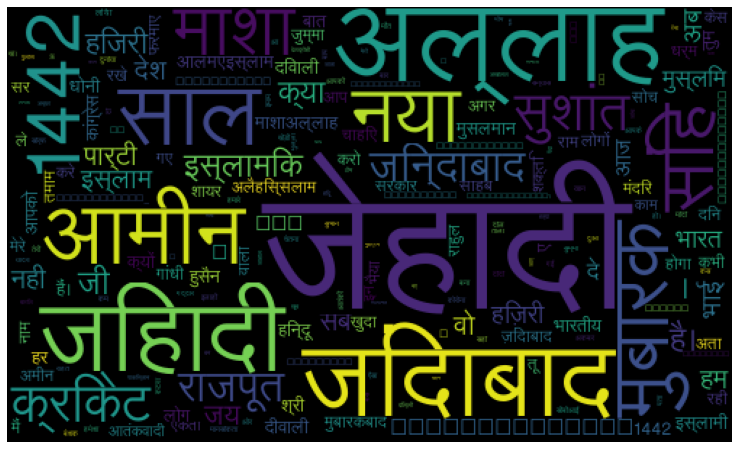

In [50]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from wordcloud import WordCloud, ImageColorGenerator


pos_data = data.loc[data['Label'] == 1]
pos_head_lines = Tokenize(pos_data)
#pos_head_lines = tweets
pos_lines = [j for sub in pos_head_lines for j in sub] 
pos_lines = [clean_text(w) for w in pos_lines if not w in hin_stopwords]
word_could_dict=Counter(pos_lines)
# text = ''
# for m in pos_lines:
#     text = text + m + ' '

wordcloud = WordCloud(font_path='Devanagari/Lohit-Devanagari.ttf',width = 500, height = 300, stopwords = hin_stopwords).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

### Splitting data

In [51]:
validation_split = 0.1
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tweets)
sequences = tokenizer_obj.texts_to_sequences(tweets)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['Label'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

le = LabelEncoder()
sentiment = le.fit_transform(sentiment)
# transfor from a array to a vector
sentiment = sentiment.reshape(-1,1)


num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]

X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


unique tokens -  18784
vocab size - 18785


In [52]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (9111, 25)
Shape of y_train: (9111, 3)
Shape of X_test_pad: (1012, 25)
Shape of y_test: (1012, 3)


### Glove glove.6B.300d

In [28]:
embeddings_index = {}

# Glove from paper DSWI
f = open('glove.6B.300d.txt', encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))



Found 400000 word vectors.


In [53]:
embedding_dim = 300

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector

In [54]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

## LSTM Model

In [55]:
def createModel(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.50))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.RMSprop(learning_rate=1e-3), metrics=['acc'])
    return model

model = createModel(embedding_layer)
model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 300)           5635500   
_________________________________________________________________
lstm_11 (LSTM)               (None, 256)               570368    
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 771       
Total params: 6,206,639
Trainable params: 571,139
Non-trainable params: 5,635,500
_________________________________________________________________


In [56]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=5, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/5
285/285 - 26s - loss: 1.0178 - acc: 0.3992 - val_loss: 1.0015 - val_acc: 0.4071
Epoch 2/5
285/285 - 25s - loss: 0.9997 - acc: 0.4249 - val_loss: 0.9953 - val_acc: 0.4377
Epoch 3/5
285/285 - 25s - loss: 0.9852 - acc: 0.4355 - val_loss: 1.0019 - val_acc: 0.4121
Epoch 4/5
285/285 - 25s - loss: 0.9804 - acc: 0.4432 - val_loss: 1.0043 - val_acc: 0.4407
Epoch 5/5
285/285 - 25s - loss: 0.9747 - acc: 0.4371 - val_loss: 1.0071 - val_acc: 0.4091


In [57]:
results = model.evaluate(X_test_pad, y_test, batch_size=32)

32/32 [==============================] - 1s 20ms/step - loss: 1.0071 - acc: 0.4091


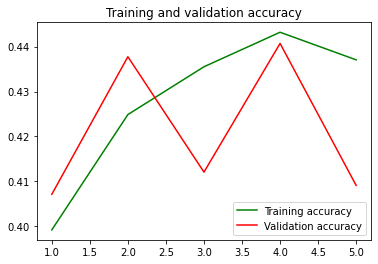

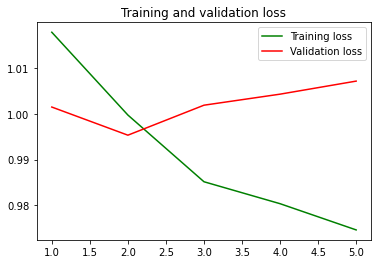

In [58]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 10 Fold cross validation

In [59]:
import random
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import KFold
# KFold cross-validation
kFold = 10
scores = []
validation_split = 0.1
max_length = 25
results = []
train_res = []
print("LSTM with Glove from Stanford NLP: ")
for i in range(kFold):
    print("Fold: ", i+1)
    prediction_val = []
    Y_test = []
    scores=[]
    random_shuff = random.randint(1, 7000)
    X_train_pad, X_test_pad, y_train, y_test = train_test_split(lines_pad, to_categorical(sentiment), test_size=0.10, shuffle = True, random_state=random_shuff)
    model = createModel(embedding_layer)
    history = model.fit(X_train_pad, y_train, batch_size=32, epochs=6, validation_data=(X_test_pad, y_test), verbose=1)
    
    print("Results for current fold:")
    print("Evaluating on train data:")
    train_res.append(model.evaluate(X_train_pad, y_train, batch_size=128))
    print("Evaluating on test data:")
    results.append(model.evaluate(X_test_pad, y_test, batch_size=128))
    
    y_pred = model.predict(X_test_pad)
    for p in y_pred:
        prediction_val.append(np.argmax(p))
    for t in y_test:
        Y_test.append(np.argmax(t))
    scoreValue = accuracy_score(Y_test,prediction_val)
    scores.append(scoreValue)



LSTM with Glove from Stanford NLP: 
Fold:  1
Epoch 1/6
285/285 [==============================] - 26s 92ms/step - loss: 1.0178 - acc: 0.4159 - val_loss: 1.0137 - val_acc: 0.4067
Epoch 2/6
285/285 [==============================] - 26s 90ms/step - loss: 0.9925 - acc: 0.4273 - val_loss: 1.0099 - val_acc: 0.4097
Epoch 3/6
285/285 [==============================] - 26s 90ms/step - loss: 0.9832 - acc: 0.4387 - val_loss: 1.0100 - val_acc: 0.4038
Epoch 4/6
285/285 [==============================] - 26s 89ms/step - loss: 0.9782 - acc: 0.4347 - val_loss: 1.0077 - val_acc: 0.4195
Epoch 5/6
285/285 [==============================] - 25s 89ms/step - loss: 0.9660 - acc: 0.4487 - val_loss: 1.0151 - val_acc: 0.4215
Epoch 6/6
285/285 [==============================] - 25s 89ms/step - loss: 0.9652 - acc: 0.4438 - val_loss: 1.0197 - val_acc: 0.4215
Results for current fold:
Evaluating on train data:
72/72 [==============================] - 4s 54ms/step - loss: 0.9659 - acc: 0.4439
Evaluating on test dat

In [60]:
import statistics 

score = []
for i in results:
    score.append(i[1])
x = statistics.mean(score)
    
print("Kfold Mean: ", x)

Kfold Mean:  0.42606120705604555


### Confusion matrix

In [61]:
results2 = confusion_matrix(Y_test,prediction_val)
print ('Confusion Matrix :')
print(results2) 
print ('Accuracy Score :',accuracy_score(Y_test,prediction_val))
print ('Report : ')
print (classification_report(Y_test,prediction_val))

Confusion Matrix :
[[284  11  12]
 [246  82  10]
 [323   3  42]]
Accuracy Score : 0.4027640671273445
Report : 
              precision    recall  f1-score   support

           0       0.33      0.93      0.49       307
           1       0.85      0.24      0.38       338
           2       0.66      0.11      0.19       368

    accuracy                           0.40      1013
   macro avg       0.61      0.43      0.35      1013
weighted avg       0.62      0.40      0.35      1013

